<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/endToEndTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook includes end to end from DICOM files to Inference and creating DICOM SEG and DICOM SR Objects**



Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

###**Installing Packages**

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 dcm2niix wget pigz xvfb plastimatch ffmpeg

In [ ]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics nibabel required for extracting radiomics features
# #p_tqdm tqdm for monitoring progress of radiomics features extraction
# #nvidia-ml-py3 for capturing gpu utilization

# !pip install pyradiomics nibabel p_tqdm tqdm pydicom TotalSegmentator nvidia-ml-py3 

In [ ]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_download_path = f"dcmqi-1.2.5-linux.tar.gz"
# dcmqi_path = f"dcmqi-1.2.5-linux"

# !wget -O $dcmqi_download_path $dcmqi_release_url

# !tar -xvf $dcmqi_download_path 

# !mv $dcmqi_path/bin/* /bin
# !rm -r $dcmqi_download_path $dcmqi_path

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd
# !rm CHANGELOG.md LICENSE README.md

###**Importing Packages**

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from functools import partial
import glob
import json
import logging
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import nvidia_smi
import os
from pathlib import Path
import pandas as pd
import psutil
import radiomics
from radiomics import featureextractor
import shutil
import SimpleITK as sitk
import subprocess
import sys
from time import sleep
import time
import tqdm
from tqdm.contrib.concurrent import process_map
from pydicom.filereader import dcmread

logging.getLogger('pyradiomics').setLevel(logging.CRITICAL)

curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Mon May 29 22:37:31 2023

Current directory :/content
Python version    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


###**Parameters for Papermill**

In [ ]:
csvFilePath=''
converterType='dcm2niix'

###**For local testing**

In [ ]:
# try:
#   os.remove(f'{curr_dir}/batch_1.csv')
# except OSError:
#   pass

# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# csvFilePath =glob.glob('*.csv')[0]

--2023-05-29 22:37:31--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.003s  

2023-05-29 22:37:31 (52.3 MB/s) - ‘batch_1.csv’ saved [139861/139861]



###Reading CSV File containing s5cmd Urls

In [ ]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.006911039352416992  seconds


In [ ]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
SeriesInstanceUIDs

['1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033',
 '1.2.840.113654.2.55.100875189782210690344207306235124901243',
 '1.2.840.113654.2.55.113040386178547843571271236478024341696',
 '1.2.840.113654.2.55.142419057730651121165090739113900499978',
 '1.2.840.113654.2.55.14382674871619950799472325766084940706',
 '1.2.840.113654.2.55.146601594654322994982630019583270053397',
 '1.2.840.113654.2.55.154809705591242159075253605419469935510',
 '1.2.840.113654.2.55.185309182591805634517860395342326800332',
 '1.2.840.113654.2.55.216614002338888733987350522981366678482',
 '1.2.840.113654.2.55.22770087029972268579113866309746562015',
 '1.2.840.113654.2.55.243990451406006403331425809632881193215']

###Downloading Config for DICOM_SEG conversion and Label maps from TotalSegmentator

In [ ]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
  os.remove(f'{curr_dir}/map_to_binary.py')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
!wget https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
import map_to_binary

--2023-05-29 22:37:31--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76948 (75K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  75.14K  --.-KB/s    in 0.001s  

2023-05-29 22:37:31 (67.5 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [76948/76948]

--2023-05-29 22:37:32--  https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gith

In [ ]:
totalsegmentator_segments_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/TotalSegmentator%20v1%20SCT%20mapping%20-%20total.csv',index_col=[0], dtype={'SegmentedPropertyTypeModifierCodeSequence.CodeValue': str})
totalsegmentator_radiomics_features_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/radiomicsFeaturesMaps.csv',index_col=[0])
#totalsegmentator_radiomics_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class'] == 'firstorder']
totalsegmentator_radiomics_features_code_mapping_df


,feature,pyradiomics_feature_class,pyradiomics_notes,quantity_CodingSchemeDesignator,quantity_CodeValue,quantity_CodeMeaning,units_CodingSchemeDesignator,units_CodeValue,units_CodeMeaning
0,Elongation,shape,NaN,IBSI,Q3CK,Elongation,UCUM,1,no units
1,Flatness,shape,NaN,IBSI,N17B,Flatness,UCUM,1,no units
2,LeastAxisLength,shape,NaN,IBSI,7J51,Least axis length,UCUM,mm,millimeter
3,MajorAxisLength,shape,NaN,IBSI,TDIC,Major axis length,UCUM,mm,millimeter
4,Maximum3DDiameter,shape,https://pyradiomics.readthedocs.io/en/latest/f...,IBSI,L0JK,Maximum 3D diameter,UCUM,mm,millimeter
5,MeshVolume,shape,NaN,IBSI,RNU0,Volume,UCUM,mm3,cubic millimeter
6,MinorAxisLength,shape,NaN,IBSI,P9VJ,Minor axis length,UCUM,mm,millimeter
7,Sphericity,shape,NaN,IBSI,QCFX,Sphericity,UCUM,1,no units
8,SurfaceArea,shape,Calculated using Marching Cubes,IBSI,C0JK,Surface area,UCUM,mm2,square millimeter
9,SurfaceVolumeRatio,shape,NaN,IBSI,2PR5,Surface to volume ratio,UCUM,/mm,per millimeter


###**Functions**

In [ ]:
try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')  
  shutil.rmtree(f'itkimage2segimage')
  shutil.rmtree(f'radiomics')
  shutil.rmtree(f'{converterType}')
  shutil.rmtree(f'structuredReportsDICOM')
  shutil.rmtree(f'structuredReportsJSON')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')   
os.mkdir(f'itkimage2segimage')
os.mkdir(f'radiomics')
os.mkdir(f'{converterType}')
os.mkdir(f'structuredReportsDICOM')
os.mkdir(f'structuredReportsJSON')

In [ ]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files
    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz

In [ ]:
def check_dicom_conversion_errors(series_id_folder_path):
    nifti_files = os.listdir(series_id_folder_path)
    if len(nifti_files) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id_folder_path}\n")
        return True
    else:
        return False

In [ ]:
def check_total_segmentator_errors(series_id):
    try:
        # Check if the output files from TotalSegmentator exist
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/segmentations.nii")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/statistics_radiomics.json")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/preview_total.png")
    except AssertionError:
        # If any of the output files do not exist, log an error
        with open('totalsegmentator_errors.txt', 'a') as f:
            f.write(f"Error: TotalSegmentator failed for series {series_id}\n")
        return True
    return False

In [ ]:
#set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING) 

In [ ]:
def get_radiomics_features(seg_file, img_file, label=None):
    try:
      standard_features = ['shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 'firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Energy', 'firstorder_Entropy', 'firstorder_InterquartileRange', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean', 'firstorder_Median', 'firstorder_Minimum', 'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_RootMeanSquared', 'firstorder_Skewness', 'firstorder_TotalEnergy', 'firstorder_Uniformity', 'firstorder_Variance', 'glcm_Autocorrelation', 'glcm_ClusterProminence', 'glcm_ClusterShade', 'glcm_ClusterTendency', 'glcm_Contrast', 'glcm_Correlation', 'glcm_DifferenceAverage', 'glcm_DifferenceEntropy', 'glcm_DifferenceVariance', 'glcm_Id', 'glcm_Idm', 'glcm_Idmn', 'glcm_Idn', 'glcm_Imc1', 'glcm_Imc2', 'glcm_InverseVariance', 'glcm_JointAverage', 'glcm_JointEnergy', 'glcm_JointEntropy', 'glcm_MCC', 'glcm_MaximumProbability', 'glcm_SumAverage', 'glcm_SumEntropy', 'glcm_SumSquares', 'gldm_DependenceEntropy', 'gldm_DependenceNonUniformity', 'gldm_DependenceNonUniformityNormalized', 'gldm_DependenceVariance', 'gldm_GrayLevelNonUniformity', 'gldm_GrayLevelVariance', 'gldm_HighGrayLevelEmphasis', 'gldm_LargeDependenceEmphasis', 'gldm_LargeDependenceHighGrayLevelEmphasis', 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_LowGrayLevelEmphasis', 'gldm_SmallDependenceEmphasis', 'gldm_SmallDependenceHighGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'glrlm_GrayLevelNonUniformity', 'glrlm_GrayLevelNonUniformityNormalized', 'glrlm_GrayLevelVariance', 'glrlm_HighGrayLevelRunEmphasis', 'glrlm_LongRunEmphasis', 'glrlm_LongRunHighGrayLevelEmphasis', 'glrlm_LongRunLowGrayLevelEmphasis', 'glrlm_LowGrayLevelRunEmphasis', 'glrlm_RunEntropy', 'glrlm_RunLengthNonUniformity', 'glrlm_RunLengthNonUniformityNormalized', 'glrlm_RunPercentage', 'glrlm_RunVariance', 'glrlm_ShortRunEmphasis', 'glrlm_ShortRunHighGrayLevelEmphasis', 'glrlm_ShortRunLowGrayLevelEmphasis', 'glszm_GrayLevelNonUniformity', 'glszm_GrayLevelNonUniformityNormalized', 'glszm_GrayLevelVariance', 'glszm_HighGrayLevelZoneEmphasis', 'glszm_LargeAreaEmphasis', 'glszm_LargeAreaHighGrayLevelEmphasis', 'glszm_LargeAreaLowGrayLevelEmphasis', 'glszm_LowGrayLevelZoneEmphasis', 'glszm_SizeZoneNonUniformity', 'glszm_SizeZoneNonUniformityNormalized', 'glszm_SmallAreaEmphasis', 'glszm_SmallAreaHighGrayLevelEmphasis', 'glszm_SmallAreaLowGrayLevelEmphasis', 'glszm_ZoneEntropy', 'glszm_ZonePercentage', 'glszm_ZoneVariance', 'ngtdm_Busyness', 'ngtdm_Coarseness', 'ngtdm_Complexity', 'ngtdm_Contrast', 'ngtdm_Strength']
      settings = {}
      settings["resampledPixelSpacing"] = [3,3,3]
      settings["geometryTolerance"] = 1e-3
      settings["featureClass"] = ["shape"]
      radiomics.setVerbosity(logging.CRITICAL)
      extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
      extractor.disableAllFeatures()
      #extractor.enableFeatureClassByName("shape")
      #extractor.enableFeatureClassByName("firstorder")
      shape_features_list = list(totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['feature']=='shape'].values)
      firstorder_features = list(totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['feature']=='firstorder'].values)
      extractor.enableFeaturesByName(shape=shape_features_list)
      extractor.enableFeaturesByName(firstorder=firstorder_features)
      features = extractor.execute(str(img_file), str(seg_file), label=label)
      features = {k.replace("original_", ""): v for k, v in features.items() if k.startswith("original_")}
      features = {k: round(float(v), 4) for k, v in features.items()}
    except Exception as e:
      print(f"WARNING: radiomics raised an exception (settings all features to 0): {e}")
      features = {feat: 0 for feat in standard_features}

    return label, features

In [ ]:
# from tqdm import tqdm
# import multiprocessing
# from functools import partial

# def process_mask(seg_file, ct_file, label_id_body_part_df, label):
#     mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
#     mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
#     body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
#     return (body_part, mask_stats)

# def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
#     label_id_body_part_data = map_to_binary.class_map['total'].items()
#     # create a DataFrame from the extracted data
#     label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
#     stats = {}
#     labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
#     with multiprocessing.Pool() as pool:
#         func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
#         results = list(tqdm(pool.imap(func, labels), total=len(labels)))
#     for body_part, mask_stats in results:
#         stats[body_part] = mask_stats
#     with open(file_out, "w") as f:
#         json.dump(stats, f, indent=4)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
def process_mask(seg_file, ct_file, label_id_body_part_df, label):
    mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
    mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
    body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
    return (body_part, mask_stats)

def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
    label_id_body_part_data = map_to_binary.class_map['total'].items()
    # create a DataFrame from the extracted data
    label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
    stats = {}
    labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
    with ThreadPoolExecutor() as executor:
        func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
        results = list(tqdm(executor.map(func, labels), total=len(labels)))
    for body_part, mask_stats in results:
        stats[body_part] = mask_stats
    with open(file_out, "w") as f:
        json.dump(stats, f, indent=4)

In [ ]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            try:
                os.rmdir(dirpath)
            except OSError as e:
                print(f"Error: Failed to remove directory {dirpath}: {e}")

In [ ]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'Inference/'))

In [ ]:
def check_itkimage_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

In [ ]:
def check_radiomics_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True
    return False

In [ ]:
def order_dicom_files_image_position(dcm_directory):
  """
  Orders the dicom files according to image position and orientation. 

  Arguments:
    dcm_directory : input directory of dcm files to put in order 

  Outputs:
    files_sorted   : dcm files in sorted order 
    sop_all_sorted : the SOPInstanceUIDs in sorted order 
    pos_all_sorted : the image position in sorted order 

  """
  files = [os.path.join(dcm_directory,f) for f in os.listdir(dcm_directory)]

  num_files = len(files)

  pos_all = []  
  sop_all = [] 

  for n in range(0,num_files):
    # read dcm file 
    filename = files[n]
    ds = dcmread(filename)

    # get ImageOrientation (0020, 0037)
    # ImageOrientation = ds['0x0020','0x0037'].value
    ImageOrientation = ds.ImageOrientationPatient

    # get ImagePositionPatient (0020, 0032) 
    # ImagePositionPatient = ds['0x0020','0x0032'].value
    ImagePositionPatient = ds.ImagePositionPatient

    # calculate z value
    x_vector = ImageOrientation[0:3]
    y_vector = ImageOrientation[3:]
    z_vector = np.cross(x_vector,y_vector)

    # multiple z_vector by ImagePositionPatient
    pos = np.dot(z_vector,ImagePositionPatient)
    pos_all.append(pos)

    # get the SOPInstanceUID 
    # sop = ds['0x0008', '0x0018'].value
    sop = ds.SOPInstanceUID
    sop_all.append(sop)


  #----- order the SOPInstanceUID/files by z value ----# 

  sorted_ind = np.argsort(pos_all)
  pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
  sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
  files_sorted = np.array(files)[sorted_ind.astype(int)]

  return files_sorted, sop_all_sorted, pos_all_sorted 

In [ ]:
def create_structured_report_metajson_for_shape_features(SeriesInstanceUID, 
                                                         SOPInstanceUID_seg,
                                                         seg_file, 
                                                         dcm_directory, 
                                                         segments_code_mapping_df,
                                                         features_code_mapping_df,
                                                         radiomics_features, 
                                                         ):
  
  """Function that creates the metajson necessary for the creation of a
  structured report from a pandas dataframe of label names and features for 
  each. 

  Inputs: 
    SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT 
                                      file 
    SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file 
    seg_file                        : filename of SEG DCM file 
    dcm_directory                   : ct directory that will be sorted in 
                                      terms of axial ordering according to the 
                                      ImagePositionPatient and ImageOrientation 
                                      fields
    segments_code_mapping_df        : dataframe that holds the names of the 
                                      segments and the associated code values etc.
    features_code_mapping_df        : dataframe that holds the names of the 
                                      features and the associated code values etc. 
    df_features                     : a pandas dataframe holding the segments and a 
                                      set of 3D shape features for each 

  Outputs:
    Returns the metajson for the structured report that will then be used by
    dcmqi tid1500writer to create a structured report 
  """ 
  # --- Get the version number for the pyradiomics package --- #

  pyradiomics_version_number = str(radiomics.__version__)
  
  # --- Sort the dcm files first according to --- # 
  # --- ImagePositionPatient and ImageOrientation --- #

  files_sorted, sop_all_sorted, pos_all_sorted = order_dicom_files_image_position(dcm_directory)
  files_sorted = [os.path.basename(f) for f in files_sorted]

  # --- Create the header for the json --- # 
  
  inputMetadata = {}
  inputMetadata["@schema"]= "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
  inputMetadata["SeriesDescription"] = "Measurements"
  inputMetadata["SeriesNumber"] = "1001"
  inputMetadata["InstanceNumber"] = "1"

  inputMetadata["compositeContext"] = [seg_file] # not full path

  inputMetadata["imageLibrary"] = files_sorted # not full path 
  inputMetadata["observerContext"] = {
                      "ObserverType": "DEVICE",
                      "DeviceObserverName": "pyradiomics",
                      "DeviceObserverModelName": pyradiomics_version_number
                    }

  inputMetadata["VerificationFlag"]  = "UNVERIFIED"
  inputMetadata["CompletionFlag"] =  "COMPLETE"
  inputMetadata["activitySession"] = "1"
  inputMetadata["timePoint"] = "1"

  # ------------------------------------------------------------------------- # 
  # --- Create the measurement_dict for each segment - holds all features --- # 

  measurement = [] 

  # --- Now create the dict for all features and all segments --- #

  # --- Loop over the number of segments --- #

  # number of rows in the df_features 
  num_segments = radiomics_features.shape[0]
  print(num_segments)

  # Array of dictionaries - one dictionary for each segment 
  measurement_across_segments_combined = [] 

  for segment_id in range(0,num_segments):

    ReferencedSegment = int(radiomics_features['label_id'].values[segment_id]) # referencedsegment must be an integer according to the schema.
    FindingSite = radiomics_features['body_part'].values[segment_id]

    # --- Create the dict for the Measurements group --- # 
    TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

    segment_row = segments_code_mapping_df[segments_code_mapping_df["Structure"] == FindingSite]


    # Inside the loop for each segment
    my_dict = {
      "TrackingIdentifier": str(TrackingIdentifier),
      "ReferencedSegment": int(ReferencedSegment),
      "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
      "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
      "Finding": {
        "CodeValue": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeMeaning"].iloc[0]),
      }, 
      "FindingSite": {
        "CodeValue": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]),
      }
    }

    laterality_dict = {
      "CodeValue": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[0]),
      "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"].iloc[0]),
      "CodeMeaning": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"].iloc[0])
    }

    # Check if the laterality dictionary is empty
    #if all(laterality_dict.values()) and not any(pd.isna(list(laterality_dict.values()))):
     # my_dict["Laterality"] = laterality_dict

    #Append the remaining code after creating the measurement_across_segments_combined array
    #Check if the laterality dictionary is empty or contains NaN values
    if laterality_dict and not any(value == 'nan' or pd.isna(value) for value in laterality_dict.values()):
      my_dict["Laterality"] = laterality_dict
        
    measurement = []  
    # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
    num_values = len(radiomics_features.columns)-2 

    #feature_list = radiomics_features.columns[2:] # remove first two 
    feature_list = features_code_mapping_df.feature.to_list()

    # For each measurement per region segment
    for n in range(0,len(feature_list)): 
      measurement_dict = {}
      row = radiomics_features.loc[radiomics_features['body_part'] == FindingSite]
      feature_row = features_code_mapping_df.loc[features_code_mapping_df["feature"] == feature_list[n]]
      value = str(np.round(row[feature_list[n]].values[0],3))
      measurement_dict["value"] = value
      measurement_dict["quantity"] = {}
      measurement_dict["quantity"]["CodeValue"] = str(feature_row["quantity_CodeValue"].values[0])
      measurement_dict["quantity"]["CodingSchemeDesignator"] = str(feature_row["quantity_CodingSchemeDesignator"].values[0])
      measurement_dict["quantity"]["CodeMeaning"] = str(feature_row["quantity_CodeMeaning"].values[0])
      measurement_dict["units"] = {}
      measurement_dict["units"]["CodeValue"] = str(feature_row["units_CodeValue"].values[0])
      measurement_dict["units"]["CodingSchemeDesignator"] = str(feature_row["units_CodingSchemeDesignator"].values[0])
      measurement_dict["units"]["CodeMeaning"] = str(feature_row["units_CodeMeaning"].values[0])
      measurement_dict["measurementAlgorithmIdentification"] = {}
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmName"] = "pyradiomics"
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmVersion"] = str(pyradiomics_version_number)
      measurement.append(measurement_dict) 

    measurement_combined_dict = {}
    measurement_combined_dict['measurementItems'] = measurement # measurement is an array of dictionaries 

    output_dict_one_segment = {**my_dict, **measurement_combined_dict}

    # append to array for all segments 

    measurement_across_segments_combined.append(output_dict_one_segment)

  # --- Add the measurement data --- # 

  inputMetadata["Measurements"] = {}
  inputMetadata["Measurements"] = measurement_across_segments_combined
  feature_type = features_code_mapping_df['pyradiomics_feature_class'].iloc[0]
  sr_json_path=f'{curr_dir}/structuredReportsJSON/{series_id}/{series_id}_{feature_type}_sr.json'
  sr_path=f'{curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_{feature_type}_sr.dcm'
  pred_dicomseg_path=f'{curr_dir}/itkimage2segimage/{series_id}'

  with open(sr_json_path, 'w') as f:
    json.dump(inputMetadata, f, indent=2)
    print (f'wrote out json for {feature_type} features')

  inputImageLibraryDirectory = dcm_directory
  # outputDICOM = sr_json_path
  outputDICOM = sr_path
  # the name of the folder where the seg files are located 
  inputCompositeContextDirectory = pred_dicomseg_path 
  inputMetadata_json = sr_json_path 

  print ('inputImageLibraryDirectory: ' + str(inputImageLibraryDirectory))
  print ('outputDICOM: ' + str(outputDICOM))
  print ('inputCompositeContextDirectory: ' + str(inputCompositeContextDirectory))
  print ('inputMetadata_json: ' + str(inputMetadata_json)) 
  !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
                --outputDICOM $outputDICOM  \
                --inputCompositeContextDirectory $inputCompositeContextDirectory \
                --inputMetadata $sr_json_path
  print (f'wrote out SR for {feature_type} radiomics features')

  

In [ ]:
def endToEndTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'itkimage2segimage/{series_id}')
        shutil.rmtree(f'radiomics/{series_id}')
        shutil.rmtree(f'structuredReportsDICOM/{series_id}')
        shutil.rmtree(f'structuredReportsJSON/{series_id}')
      except OSError:
        pass
        os.mkdir(f'Inference/{series_id}')
        os.mkdir(f'itkimage2segimage/{series_id}')
        os.mkdir(f'radiomics/{series_id}')
        os.mkdir(f'structuredReportsDICOM/{series_id}')
        os.mkdir(f'structuredReportsJSON/{series_id}')

      print("Processing series: "+series_id)  


      start_time = time.time()
      download_dicom_data(series_id) 
      dicom_download_time = time.time() - start_time 

      start_time = time.time()
      convert_dicom_to_nifti(series_id)
      dicom_conversion_time = time.time() - start_time


      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)

      if not check_dicom_conversion_errors(series_id_folder_path):


        #Get Inference NIFTI file path
        inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
        inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
        
        start_time = time.time()
        #!TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
        result=subprocess.run(['TotalSegmentator', '-i', nifti_filename_path, '-o', 'segmentations', '--ml'],stdout=subprocess.PIPE, stderr=subprocess.PIPE,  universal_newlines=True)
        print(result.stdout)
        total_segmentator_time = time.time() - start_time

        try:
          subprocess.run(["mv", f"{curr_dir}/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
          print("Files moved successfully using the first command")
        except subprocess.CalledProcessError:
          try:
            subprocess.run(["mv", "segmentations/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
          except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")

        check_total_segmentator_errors(series_id)
        
        !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii


        start_time = time.time()
        !itkimage2segimage --inputImageList {curr_dir}/Inference/{series_id}/{series_id}.nii --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole_slicerAsRef.json --skip >> /dev/null
        itkimage2segimage_time = time.time() - start_time
        print("Done in %g seconds."%itkimage2segimage_time)
        
        check_itkimage_errors(series_id)


        ct_series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
        # Get the list of files in series_id_path
        ct_nifti_files = os.listdir(ct_series_id_folder_path)
        # Get the first (and only) file in the list
        ct_nifti_filename = ct_nifti_files[0]
        # Get the full path of the file
        ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)
        
        radiomics_output_filename= os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json')
        
        start_time = time.time()   
        get_radiomics_features_for_all_labels(ct_nifti_filename_path, inference_nifti_filename, radiomics_output_filename)
        radiomics_time = time.time() - start_time
        print("Radiomics Features Calculation Done in %g seconds."%radiomics_time)
        
        check_radiomics_errors(series_id)

        start_time = time.time()   

        radiomics_features = pd.read_json(os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json'), orient='index')
        radiomics_features = radiomics_features.rename(columns=lambda x: x.split('_')[-1])
        radiomics_features = radiomics_features.reset_index().rename(columns={'index': 'body_part'})
        label_id_body_part_data = map_to_binary.class_map['total'].items()
        label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
        radiomics_features = pd.merge(radiomics_features, label_id_body_part_df, on='body_part')
        cols = radiomics_features.columns.tolist()
        cols.insert(1, cols.pop(cols.index('label_id')))
        radiomics_features = radiomics_features[cols]

        seg_dcm=dcmread(f'{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm')
        SOPInstanceUID_seg=seg_dcm.file_meta['0x0002', '0x0003'].value

        seg_file=f'{series_id}.dcm'
        dcm_directory=f'{curr_dir}/idc_data' 
        segments_code_mapping_df= totalsegmentator_segments_code_mapping_df
        shape_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='shape']
        first_order_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='firstorder']

        create_structured_report_metajson_for_shape_features( series_id, 
                                                              SOPInstanceUID_seg,
                                                              seg_file, 
                                                              dcm_directory, 
                                                              segments_code_mapping_df,
                                                              shape_features_code_mapping_df,
                                                              radiomics_features, 
                                                              )
        create_structured_report_metajson_for_shape_features( series_id, 
                                                              SOPInstanceUID_seg,
                                                              seg_file, 
                                                              dcm_directory, 
                                                              segments_code_mapping_df,
                                                              first_order_features_code_mapping_df,
                                                              radiomics_features, 
                                                              )
        structuredReportsGenerationTime = time.time() - start_time
        print("Structured Reports Generated in %g seconds."%structuredReportsGenerationTime)


        start_time = time.time()     
        !lz4 --rm {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
        !lz4 --rm {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json  {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json.lz4
        !lz4 --rm {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_shape_sr.dcm  {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_shape_sr.dcm.lz4
        !lz4 --rm {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_firstorder_sr.dcm  {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_firstorder_sr.dcm.lz4
        !lz4 --rm {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_shape_sr.json  {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_shape_sr.json.lz4
        !lz4 --rm {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_firstorder_sr.json  {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_firstorder_sr.json.lz4

        archiving_time = time.time() - start_time
      else: 
        total_segmentator_time=0
        archiving_time=0
        itkimage2segimage_time =0
        radiomics_time=0 
        structuredReportsGenerationTime=0


      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 

      log['dicom_download_time']=dicom_download_time
      log['dicom_conversion_time']=dicom_conversion_time
      log['total_segmentator_time'] = total_segmentator_time     
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['radiomics_time']= radiomics_time
      log['structuredReportsGenerationTime']=structuredReportsGenerationTime
      log['archiving_time'] = archiving_time


      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data
      !rm -r {curr_dir}/{converterType}/{series_id}

      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        partitions = psutil.disk_partitions()
        for partition in partitions:
            if partition.mountpoint == '/':
                return '/'
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        return '/'  # Default to root directory if no specific path is found
    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_usage = psutil.disk_usage(self.working_disk_path)
            disk_used = disk_usage.used / 1024 / 1024 / 1024
            disk_total = disk_usage.total / 1024 / 1024 / 1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total


###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345
Copying files from IDC buckets..
Done in 2.31174 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 181 DICOM file(s)
Convert 181 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2 (512x512x181x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii"
Conversion required 10.247267 seconds (0.335634 for core code).

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Download finished. Extracting...
  downloaded in 28.73s
Download finished. Extracting...
  downloade

100%|██████████| 75/75 [11:43<00:00,  9.39s/it]


Radiomics Features Calculation Done in 707.03 seconds.
75
wrote out json for shape features
inputImageLibraryDirectory: /content/idc_data
outputDICOM: /content/structuredReportsDICOM/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345_shape_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345
inputMetadata_json: /content/structuredReportsJSON/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345_shape_sr.json
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Total measurement groups: 75
Adding to compositeContext: 1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345.dcm
Composite Context has been initialized
SR saved!
wrote out SR for shape radiomics features
75
wrote out json for firstorder features
inputImageLib

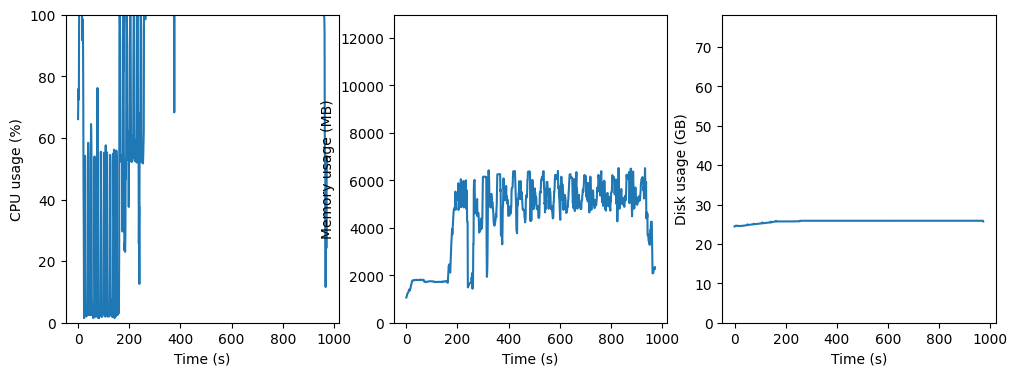

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033
Copying files from IDC buckets..
Done in 2.2104 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 115 DICOM file(s)
Convert 115 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2 (512x512x115x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii"
Conversion required 3.558266 seconds (0.228548 for core code).

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.57s
Predicting part 1 of 5 ...

If you use this tool please cite: https://d

 50%|█████     | 36/72 [03:37<02:58,  4.95s/it]

In [ ]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','dicom_download_time', 'dicom_conversion_time','total_segmentator_time', 'itkimage2segimage_time','radiomics_time',
                                      'archiving_time','structuredReportsGenerationTime', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(endToEndTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total = mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4')
  os.remove(f'{curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsDICOM.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsJSON.tar.lz4')

except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4
!tar cvf - {curr_dir}/radiomics | lz4 > {curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4
!tar cvf - {curr_dir}/structuredReportsDICOM | lz4 > {curr_dir}/structuredReportsDICOM.tar.lz4
!tar cvf - {curr_dir}/structuredReportsJSON | lz4 > {curr_dir}/structuredReportsJSON.tar.lz4

output_archiving_time = time.time() - start_time

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('dicomsegAndRadiomicsSR_UsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv dicomsegAndRadiomicsSR_UsageMetrics.lz4
runtime_stats

In [ ]:
# !find /content/cromwell_root -type f -name '*.lz4' -exec sh -c 'lz4 -d --rm "$1" "${1%.lz4}"' _ {} \;

In [ ]:
# !ls -L /cromwell_root/

In [ ]:
# !find . -name '*.dcm' -exec cp -t new_folder {} +

In [ ]:
# !zip -r a.zip /content/new_folder

In [ ]:
# import os
# import re

# # List all the files in the new_folder directory.
# files = os.listdir("/content/new_folder")

# # Create a set of unique base names.
# unique_base_names = set()

# # Iterate over the list of files.
# for file in files:
#     # Split the filename into a base name and an extension.
#     base_name, extension = os.path.splitext(file)

#     # Remove anything after the last dot or underscore, including alphabets.
#     base_name = re.sub('[A-Za-z_\.]+$', '', base_name)

#     # Add the base name to the set of unique base names.
#     unique_base_names.add(base_name)

# # Print the set of unique base names in quotes.
# print('"' + '", "'.join(unique_base_names) + '"')
